# Applying Interoperable Machine Learning in StreamPipes

The last tutorial ([Using Online Machine Learning on a StreamPipes data stream](../4-using-online-machine-learning-on-a-streampipes-data-stream)) demonstrated how patterns in streaming data can be learned online. In contrast, this tutorial demonstrates how one can apply a pre-trained machine learning (ML) model to a StreamPipes data stream making use of [ONNX](https://onnx.ai/). We will show how StreamPipes can be used for both: extracting historical data for training purposes and using model inference on live data with a pre-trained model.

## Preparation

The following lines configure the client and establish a connection to the StreamPipes instance. If you're not familiar with it or anything is unclear, please have a look at our [first tutorial](../1-introduction-to-streampipes-python-client).

In [ ]:
%pip install git+https://github.com/apache/streampipes.git#subdirectory=streampipes-client-python
%pip install scikit-learn==1.4.0 skl2onnx==1.16.0 onnxruntime==1.17.1 matplotlib==3.8.3

In [8]:
import os
from streampipes.client import StreamPipesClient
from streampipes.client.config import StreamPipesClientConfig
from streampipes.client.credential_provider import StreamPipesApiKeyCredentials

os.environ["BROKER-HOST"] = "localhost"
os.environ["KAFKA-PORT"] = "9094"  # When using Kafka as message broker

config = StreamPipesClientConfig(
    credential_provider=StreamPipesApiKeyCredentials(
        username="admin@streampipes.apache.org",
        api_key="TOKEN",
    ),
    host_address="localhost",
    https_disabled=True,
    port=80
)

client = StreamPipesClient(client_config=config)

2024-03-26 10:21:38,538 - streampipes.client.client - [INFO] - [client.py:198] [_set_up_logging] - Logging successfully initialized with logging level INFO.
2024-03-26 10:21:38,632 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:164] [_make_request] - Successfully retrieved all resources.
2024-03-26 10:21:38,634 - streampipes.client.client - [INFO] - [client.py:171] [_get_server_version] - The StreamPipes version was successfully retrieved from the backend: 0.95.0. By means of that, authentication via the provided credentials is also tested successfully.


The main objective of this tutorial is to demonstrate how to make predictions with an existing and pre-trained ML model using a StreamPipes function and ONNX. Therefore, you can skip the following sections on use case and model training if you already have an existing ONNX model and are only interested in applying it using StreamPipes.

## Machine Learning Use Case 

In this tutorial, we will use data generated by the [Machine Data Simulator](https://streampipes.apache.org/docs/pe/org.apache.streampipes.connect.iiot.adapters.simulator.machine/) adapter. More specifically, we will focus on the `flowrate` data, which consists of various sensor values coming from a water pipe system. Our goal is keep an eye on the parameter `volume_flow`, which represents the current volume flow in cubic meters/second. For this parameter, we want to detect anomalies that could indicate problems such as leaks, blockages, etc.

To get the concerned data, we simply need to create an instance of the machine data simulator and persist the data in the data lake:

</br>

![tutorial-preparation](https://raw.githubusercontent.com/apache/streampipes/dev/streampipes-client-python/docs/img/tutorial-preparation.gif)

</br>

If you choose to perform the model training step yourself, you will need to wait approximately 15 minutes for enough data to be available for model training. If you want to speed this up, you can configure a lower wait time when creating the adapter. Please be aware that this also influences the inference scenario.

## Model Training with Historic Data

As said above, the aim of our model is to detect anomalies of the `volume_flow` parameter. For this task, we will use [Isolation Forests](https://en.wikipedia.org/wiki/Isolation_forest).
Please note that the focus of the tutorial is not on training the model, so please be patient even though the training is very simplified and lacks important preparation steps such as standardization.

As a first step, lets query the `flowrate` data from the StreamPipes data lake and extract the values of `volume_flow` as a feature:

In [9]:
flowrate_df = client.dataLakeMeasureApi.get("flow-rate").to_pandas()
X = flowrate_df["volume_flow"].values.reshape(-1, 1).astype("float32")

2024-03-26 10:21:48,582 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:164] [_make_request] - Successfully retrieved all resources.


Let's fit the model to the data:

In [14]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.01)
model.fit(X)

IsolationForest(contamination=0.01)

The `contamination` parameter models the proportion of outliers in the data. See the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) for more information.

Before we convert the model to an ONNX representation, let's do a quick visual analysis of the model results:

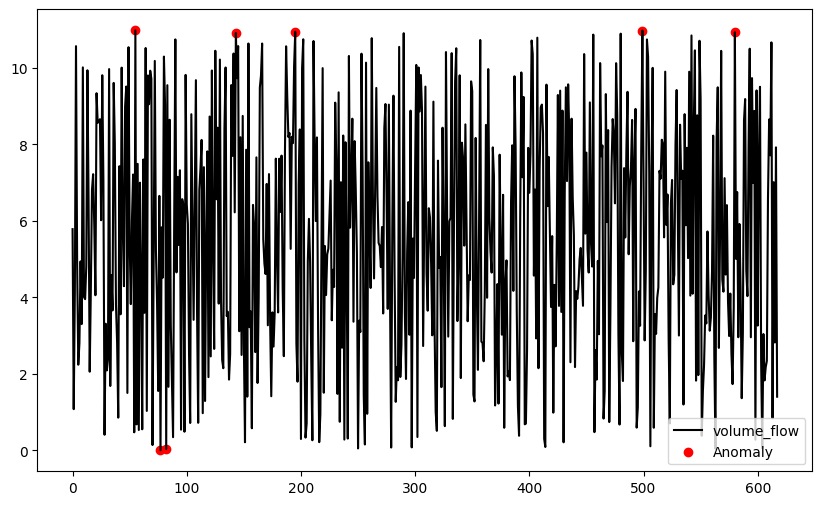

In [15]:
import matplotlib.pyplot as plt

flowrate_df["anomaly"] = model.predict(X)

fig, ax = plt.subplots(figsize=(10, 6))
anomalies = flowrate_df.loc[flowrate_df["anomaly"] == -1, ["volume_flow"]]
ax.plot(flowrate_df.index, flowrate_df['volume_flow'], color='black', label='volume_flow')
ax.scatter(anomalies.index, anomalies['volume_flow'], color='red', label='Anomaly')
plt.legend()
plt.show()

Okay, that looks quite reasonable so lets covert the model to an ONNX representation so that we can make use of it later.

In [16]:
from onnxconverter_common import FloatTensorType
from skl2onnx import to_onnx

model_onnx = to_onnx(
    model,
    initial_types=[('input', FloatTensorType([None, X.shape[1]]))],
    target_opset={'ai.onnx.ml': 3, 'ai.onnx': 15, '': 15}
)

with open("isolation_forest.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

## Model Inference with Live Data

Utilizing a pre-trained model within StreamPipes becomes seamless with the ONNX interoperability standard, enabling effortless application of your existing model on live data streams.

Interacting with live data from StreamPipes is facilitated through StreamPipes functions. Below, we'll create a Python StreamPipes function that leverages an ONNX model to generate predictions for each incoming event, making the results accessible as a data stream within StreamPipes for subsequent steps.

So let's create an `ONNXFunction` that is capable of applying a model in ONNX representation to a StreamPipes data stream. If you'd like to read more details about how functions are defined, refer to [our third tutorial](../3-getting-live-data-from-the-streampipes-data-stream).

In [23]:
import numpy as np
import onnxruntime as rt

from streampipes.functions.broker.broker_handler import get_broker_description
from streampipes.functions.streampipes_function import StreamPipesFunction
from streampipes.functions.utils.data_stream_generator import create_data_stream, RuntimeType
from streampipes.functions.utils.function_context import FunctionContext
from streampipes.model.resource import FunctionDefinition, DataStream

from typing import Dict, Any, List


class ONNXFunction(StreamPipesFunction):

    def __init__(self, feature_names: list[str], input_stream: DataStream):
        output_stream = create_data_stream(
            name="flowrate-prediction",
            attributes={
                "is_anomaly": RuntimeType.BOOLEAN.value
            },
            broker=get_broker_description(input_stream)
        )

        function_definition = FunctionDefinition(
            consumed_streams=[input_stream.element_id]
        ).add_output_data_stream(output_stream)

        self.feature_names = feature_names
        self.input_name = None
        self.output_name = None
        self.session = None

        super().__init__(function_definition=function_definition)

    def onServiceStarted(self, context: FunctionContext) -> None:
        self.session = rt.InferenceSession(
            path_or_bytes="isolation_forest.onnx",
            providers=rt.get_available_providers(),
        )
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name

    def onEvent(self, event: Dict[str, Any], streamId: str) -> None:
        feature_vector = []
        for feature in self.feature_names:
            feature_vector.append(event[feature])

        prediction = self.session.run(
            [self.output_name],
            {self.input_name: np.expand_dims(np.array(feature_vector), axis=0).astype("float32")}
        )[0]

        output = {
            "is_anomaly": int(prediction[0]) == -1
        }

        self.add_output(
            stream_id=self.function_definition.get_output_stream_ids()[0],
            event=output
        )

    def onServiceStopped(self) -> None:
        pass

Let's dive a little deeper into the different parts of the function

- **`__init__`**: First, we need to take care of the data stream that is required to send the predictions from our function to StreamPipes. Thus, we create a dedicated output data stream which we need to provide with the attributes our event will consist of (a timestamp attribute is always added automatically). This output data stream needs to be registered at the function definition which is to be passed to the parent class. Lastly, we need to define some instance variables that are mainly required for the ONNX runtime.

- **`onServiceStarted`**: Here we prepare the ONNX runtime session by creating an `InferenceSession` and retrieving the corresponding configuration parameters.

- **`onEvent`**: Following the parameter names specified by `self.feature_names`, we extract all feature values from the current event. Subsequently, the corresponding feature vector is transmitted to the ONNX runtime session. The resulting prediction is then converted into our output event, where a value of `-1` signifies an anomaly. Finally, the generated output event is forwarded to StreamPipes.


Having the function code in place, we can start the function with the following:

In [25]:
from streampipes.functions.registration import Registration
from streampipes.functions.function_handler import FunctionHandler

stream = [
    stream
    for stream
    in client.dataStreamApi.all()
    if stream.name == "flow-rate"
][0]

function = ONNXFunction(
    feature_names=["volume_flow"],
    input_stream=stream
)

registration = Registration()
registration.register(function)
function_handler = FunctionHandler(registration, client)
function_handler.initializeFunctions()

2024-03-26 12:39:50,443 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:164] [_make_request] - Successfully retrieved all resources.
2024-03-26 12:39:50,502 - streampipes.functions.function_handler - [INFO] - [function_handler.py:76] [initializeFunctions] - The data stream could not be created.
2024-03-26 12:39:50,503 - streampipes.functions.function_handler - [INFO] - [function_handler.py:78] [initializeFunctions] - This is due to the fact that this data stream already exists. Continuing with the existing data stream.
2024-03-26 12:39:50,503 - streampipes.functions.function_handler - [INFO] - [function_handler.py:84] [initializeFunctions] - Using output data stream 'sp:spdatastream:flowrate-prediction' for function '7c06fa31-9534-4f91-9c50-b7a3607ec3dc'
2024-03-26 12:39:50,548 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:164] [_make_request] - Successfully retrieved all resources.
2024-03-26 12:39:50,549 - streampipes.functions.function_handler - [INFO] - [function_

We can now access the live values of the prediction in the StreamPipes UI, e.g., in the pipeline editor.

</br>

![prediction-data-stream](https://raw.githubusercontent.com/apache/streampipes/dev/streampipes-client-python/docs/img/tutorial-prediction-data-stream.png)

That's already it. We hope this tutorial serves as an illustration how ML models can be utilized in StreamPipes with the help of ONNX.

How do you like this tutorial? We hope you like it and would love to receive some feedback from you. Just go to our GitHub discussion page and let us know your impression. We'll read and react to them all, we promise!